In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


ViT pretrained 

In [3]:
!pip install -q transformers datasets timm


In [21]:
from transformers import ViTImageProcessor, ViTForImageClassification

# ✅ Load model from Kaggle storage
vit_model_path = "/kaggle/input/vit-base-patch16-224-in21k-folder"

# ✅ Use ViTImageProcessor instead of ViTFeatureExtractor
image_processor = ViTImageProcessor.from_pretrained(vit_model_path)

# ✅ Load the ViT Model
model = ViTForImageClassification.from_pretrained(
    vit_model_path,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

model.to(device)

print("✅ ViT Model Loaded Successfully!")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at /kaggle/input/vit-base-patch16-224-in21k-folder and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ ViT Model Loaded Successfully!


In [22]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# ✅ Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"

# ✅ Define dataset paths
train_dir = "/kaggle/input/split-dataset/ALL DATASET/training/d1/Original"
test_dir = "/kaggle/input/split-dataset/ALL DATASET/testing/d1/Original"

# ✅ Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

# ✅ Load dataset
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# ✅ Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ✅ Get number of classes
num_classes = len(train_dataset.classes)
print("✅ Classes:", train_dataset.classes)


✅ Classes: ['Benign', 'Early', 'Pre', 'Pro']


In [24]:
# ✅ Train the ViT Model
num_epochs = 10  
model.train()

for epoch in range(num_epochs):
    loop = tqdm(train_loader, leave=True)
    total_loss = 0
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    print(f"✅ Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

print("✅ ViT Model Training Complete!")


Epoch [1/10]: 100%|██████████| 50/50 [01:08<00:00,  1.36s/it, loss=0.0586]


✅ Epoch 1 Loss: 0.0633


Epoch [2/10]: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it, loss=0.0522]


✅ Epoch 2 Loss: 0.0552


Epoch [3/10]: 100%|██████████| 50/50 [01:07<00:00,  1.36s/it, loss=0.0472]


✅ Epoch 3 Loss: 0.0492


Epoch [4/10]: 100%|██████████| 50/50 [01:07<00:00,  1.36s/it, loss=0.0425]


✅ Epoch 4 Loss: 0.0444


Epoch [5/10]: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it, loss=0.0389]


✅ Epoch 5 Loss: 0.0405


Epoch [6/10]: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it, loss=0.0353]


✅ Epoch 6 Loss: 0.0371


Epoch [7/10]: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it, loss=0.0323]


✅ Epoch 7 Loss: 0.0342


Epoch [8/10]: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it, loss=0.0302]


✅ Epoch 8 Loss: 0.0315


Epoch [9/10]: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it, loss=0.0282]


✅ Epoch 9 Loss: 0.0292


Epoch [10/10]: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it, loss=0.0262]

✅ Epoch 10 Loss: 0.0271
✅ ViT Model Training Complete!



✅ Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       100
       Early       1.00      1.00      1.00       100
         Pre       1.00      1.00      1.00       100
         Pro       1.00      1.00      1.00       100

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



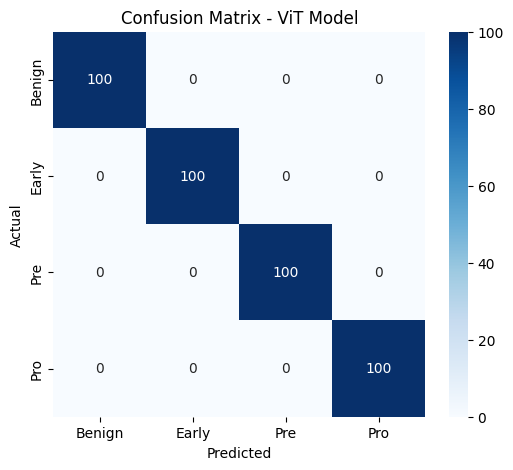

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Evaluate ViT Model
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Generate Classification Report
print("\n✅ Classification Report:\n", classification_report(all_labels, all_preds, target_names=train_dataset.classes))

# ✅ Generate Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ViT Model")
plt.show()


In [26]:
# ✅ Save the trained ViT model
save_path = "/kaggle/working/vit_model.pth"
torch.save(model.state_dict(), save_path)

print(f"✅ ViT Model Saved Successfully at {save_path}!")


✅ ViT Model Saved Successfully at /kaggle/working/vit_model.pth!


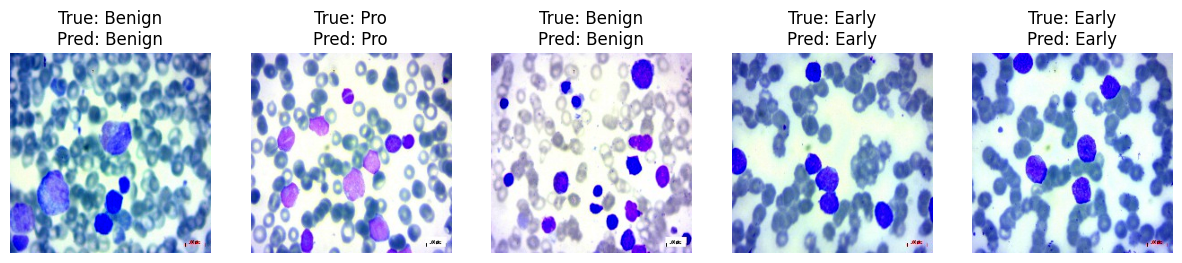

In [27]:
import random
import matplotlib.pyplot as plt

# ✅ Select random test images
num_samples = 5 
random_indices = random.sample(range(len(test_dataset)), num_samples)

# ✅ Plot and predict
fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

for i, idx in enumerate(random_indices):
    image, label = test_dataset[idx]  # Get the image and true label
    input_tensor = image.unsqueeze(0).to(device)  # Add batch dimension and move to GPU

    # ✅ Get model prediction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor).logits
        predicted_label = torch.argmax(output, dim=1).cpu().item()

    # ✅ Display Image & Prediction
    axes[i].imshow(image.permute(1, 2, 0))  # Convert tensor to image
    axes[i].axis("off")
    axes[i].set_title(f"True: {train_dataset.classes[label]}\nPred: {train_dataset.classes[predicted_label]}", fontsize=12)

plt.show()


In [14]:
import torch
import torchvision.transforms as transforms
import os
import cv2
import numpy as np
from transformers import ViTForImageClassification, ViTImageProcessor
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ✅ Define dataset path
dataset_path = "/kaggle/input/split-dataset/ALL DATASET/training/ALL_IDB2"
binary_classes = ["ALL", "Healthy"]  # ✅ Binary classification

# ✅ Load ViT Pretrained Feature Extractor
vit_model_path = "/kaggle/input/vit-base-patch16-224-in21k-folder"
processor = ViTImageProcessor.from_pretrained(vit_model_path)

# ✅ Prepare dataset
X = []
y = []

for category in binary_classes:
    category_path = os.path.join(dataset_path, category)
    
    for filename in os.listdir(category_path):
        image_path = os.path.join(category_path, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert to 3-channel RGB
        image = cv2.resize(image, (224, 224))

        X.append(image)
        y.append(category)

X = np.array(X)
y = np.array(y)

# ✅ Encode labels for binary classification
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # 0 = Healthy, 1 = ALL

# ✅ Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Convert to PyTorch tensors
transform = transforms.Compose([transforms.ToTensor()])

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = transform(self.X[idx])
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return image, label

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ✅ Load ViT Model
model = ViTForImageClassification.from_pretrained(vit_model_path, num_labels=2)
model.train()

# ✅ Define Training Loop
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(10):  # ✅ Train for 10 epochs
    epoch_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    print(f"✅ Epoch {epoch+1} Loss: {epoch_loss/len(train_loader):.4f}")

# ✅ Save Binary ViT Model
torch.save(model.state_dict(), "/kaggle/working/vit_binary_all_healthy.pth")
print("✅ ViT Binary Model (ALL vs. Healthy) Saved!")


Some weights of ViTForImageClassification were not initialized from the model checkpoint at /kaggle/input/vit-base-patch16-224-in21k-folder and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Epoch 1 Loss: 0.5727
✅ Epoch 2 Loss: 0.3100
✅ Epoch 3 Loss: 0.2139
✅ Epoch 4 Loss: 0.1135
✅ Epoch 5 Loss: 0.0567
✅ Epoch 6 Loss: 0.0360
✅ Epoch 7 Loss: 0.0262
✅ Epoch 8 Loss: 0.0208
✅ Epoch 9 Loss: 0.0176
✅ Epoch 10 Loss: 0.0154
✅ ViT Binary Model (ALL vs. Healthy) Saved!


<ipython-input-18-fa0291f31561>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


✅ ViT Binary Model Accuracy: 97.62%


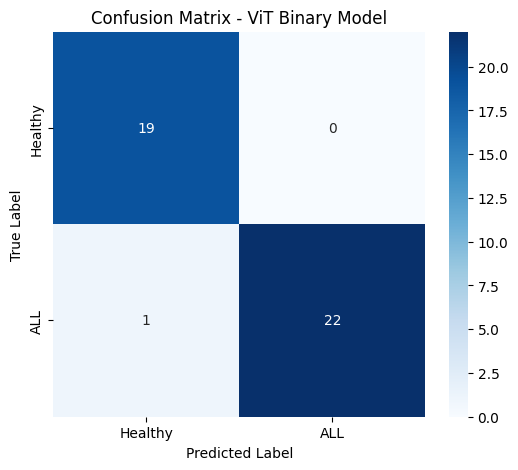


✅ Classification Report:
               precision    recall  f1-score   support

     Healthy       0.95      1.00      0.97        19
         ALL       1.00      0.96      0.98        23

    accuracy                           0.98        42
   macro avg       0.97      0.98      0.98        42
weighted avg       0.98      0.98      0.98        42



In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ✅ Load the trained model
model_path = "/kaggle/working/vit_binary_all_healthy.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# ✅ Make Predictions on Test Set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images).logits
        predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()
        
        all_preds.extend(predicted_labels)
        all_labels.extend(labels.cpu().numpy())

# ✅ Calculate Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"✅ ViT Binary Model Accuracy: {accuracy * 100:.2f}%")

# ✅ Generate Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# ✅ Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Healthy", "ALL"], yticklabels=["Healthy", "ALL"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ViT Binary Model")
plt.show()

# ✅ Print Classification Report
print("\n✅ Classification Report:\n", classification_report(all_labels, all_preds, target_names=["Healthy", "ALL"]))


MODEL from scratch 

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os

# Check GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Dataset paths
train_dir = "/kaggle/input/split-dataset/ALL DATASET/training/d1/Original"
test_dir = "/kaggle/input/split-dataset/ALL DATASET/testing/d1/Original"

Using device: cuda


In [3]:
IMG_SIZE = 224  # Required for ViT

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

def create_dataloaders(train_dir, test_dir, transform, batch_size=32, num_workers=2):
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader, train_data.classes

train_loader, test_loader, class_names = create_dataloaders(train_dir, test_dir, transform)
print(f"Classes: {class_names}")


Classes: ['Benign', 'Early', 'Pre', 'Pro']


In [8]:
import math

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # [B, E, H', W']
        x = x.flatten(2)  # [B, E, N]
        x = x.transpose(1, 2)  # [B, N, E]
        return x

class ViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, n_classes=4, emb_size=768, depth=6, heads=12, mlp_dim=2048, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, emb_size, img_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.pos_embed = nn.Parameter(torch.randn(1, (img_size // patch_size) ** 2 + 1, emb_size))

        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=heads, dim_feedforward=mlp_dim, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )

    def forward(self, x):
        x = self.patch_embed(x)  # [B, N, E]
        B, N, _ = x.shape

        cls_tokens = self.cls_token.expand(B, -1, -1)  # [B, 1, E]
        x = torch.cat((cls_tokens, x), dim=1)  # [B, N+1, E]
        x = x + self.pos_embed[:, :x.size(1), :]  # [B, N+1, E]

        x = self.transformer(x)  # [B, N+1, E]
        x = self.mlp_head(x[:, 0])  # take CLS token
        return x


In [10]:
model = ViT(n_classes=4, heads=12).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Training loop
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()

    acc = correct / len(dataloader.dataset)
    return total_loss / len(dataloader), acc


In [11]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    acc = correct / len(dataloader.dataset)
    return total_loss / len(dataloader), acc


In [12]:
EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}%")
    print(f"Test  Loss: {test_loss:.4f}, Accuracy: {test_acc*100:.2f}%\n")


Epoch 1/10
Train Loss: 1.6417, Accuracy: 24.69%
Test  Loss: 1.4175, Accuracy: 25.00%

Epoch 2/10
Train Loss: 1.4347, Accuracy: 24.38%
Test  Loss: 1.4057, Accuracy: 25.00%

Epoch 3/10
Train Loss: 1.4170, Accuracy: 23.25%
Test  Loss: 1.3857, Accuracy: 25.00%

Epoch 4/10
Train Loss: 1.4235, Accuracy: 24.69%
Test  Loss: 1.3890, Accuracy: 25.00%

Epoch 5/10
Train Loss: 1.4154, Accuracy: 25.37%
Test  Loss: 1.3868, Accuracy: 25.00%

Epoch 6/10
Train Loss: 1.4186, Accuracy: 25.06%
Test  Loss: 1.4383, Accuracy: 25.00%

Epoch 7/10
Train Loss: 1.4218, Accuracy: 24.12%
Test  Loss: 1.4065, Accuracy: 25.00%

Epoch 8/10
Train Loss: 1.4035, Accuracy: 24.38%
Test  Loss: 1.3911, Accuracy: 25.00%

Epoch 9/10
Train Loss: 1.4089, Accuracy: 24.12%
Test  Loss: 1.4088, Accuracy: 25.00%

Epoch 10/10
Train Loss: 1.4036, Accuracy: 23.75%
Test  Loss: 1.3881, Accuracy: 25.00%



In [ ]:
mobilenet+xgboost 

🚀 Starting MobileNetV2 Scratch + PCA + XGBoost pipeline...
✅ Training MobileNet scratch...
Epoch 1 - Loss: 49.3129 - Train Acc: 59.62% - Test Acc: 30.00%
Epoch 2 - Loss: 18.1283 - Train Acc: 84.69% - Test Acc: 90.50%
Epoch 3 - Loss: 10.2311 - Train Acc: 93.62% - Test Acc: 91.25%
Epoch 4 - Loss: 4.3309 - Train Acc: 98.19% - Test Acc: 89.00%
Epoch 5 - Loss: 3.1394 - Train Acc: 98.25% - Test Acc: 93.50%
Epoch 6 - Loss: 1.5044 - Train Acc: 99.19% - Test Acc: 98.75%
Epoch 7 - Loss: 0.8273 - Train Acc: 99.81% - Test Acc: 98.25%
Epoch 8 - Loss: 0.8695 - Train Acc: 99.62% - Test Acc: 98.50%
Epoch 9 - Loss: 1.3329 - Train Acc: 99.25% - Test Acc: 97.25%
Epoch 10 - Loss: 1.0837 - Train Acc: 99.50% - Test Acc: 98.25%


Extracting: 100%|██████████| 13/13 [00:01<00:00, 12.84it/s]


🎯 Training XGBoost classifier...

✅ Final Accuracy: 98.50%

✅ Classification Report:
               precision    recall  f1-score   support

      Benign       0.99      0.95      0.97       100
       Early       0.97      1.00      0.99       100
         Pre       1.00      1.00      1.00       100
         Pro       0.98      0.99      0.99       100

    accuracy                           0.98       400
   macro avg       0.99      0.99      0.98       400
weighted avg       0.99      0.98      0.98       400



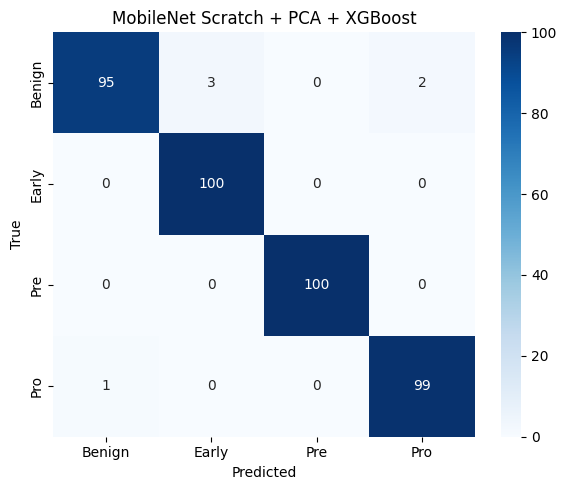

In [ ]:
print("🚀 Starting MobileNetV2 Scratch + PCA + XGBoost pipeline...")

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# 🧠 MobileNetV2 Scratch base model
class ConvBNReLU(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super().__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.ReLU6(inplace=True)
        )
class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super().__init__()
        hidden_dim = int(inp * expand_ratio)
        self.use_res_connect = (stride == 1 and inp == oup)
        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1))
        layers.extend([
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        ])
        self.conv = nn.Sequential(*layers)
    def forward(self, x):
        return x + self.conv(x) if self.use_res_connect else self.conv(x)
class MobileNetV2Scratch(nn.Module):
    def __init__(self):
        super().__init__()
        input_channel = 32
        last_channel = 1280
        self.features = nn.Sequential(
            ConvBNReLU(3, input_channel, stride=2),
            InvertedResidual(32, 16, 1, 1),
            InvertedResidual(16, 24, 2, 6),
            InvertedResidual(24, 24, 1, 6),
            InvertedResidual(24, 32, 2, 6),
            InvertedResidual(32, 32, 1, 6),
            InvertedResidual(32, 64, 2, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 96, 1, 6),
            InvertedResidual(96, 160, 2, 6),
            InvertedResidual(160, 320, 1, 6),
            ConvBNReLU(320, last_channel, kernel_size=1),
        )
        self.pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.features(x)
        return self.pool(x).view(x.size(0), -1)

# 📦 Data Loading
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_dir = "/kaggle/input/split-dataset/ALL DATASET/training/d1/Original"
test_dir = "/kaggle/input/split-dataset/ALL DATASET/testing/d1/Original"
train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)
class_names = train_data.classes

# 🧠 Model + Training
model = MobileNetV2Scratch().to(device)
classifier_head = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(1280, 4)
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(model.parameters()) + list(classifier_head.parameters()), lr=1e-4)

print("✅ Training MobileNet scratch...")
for epoch in range(10):
    model.train()
    classifier_head.train()
    total_loss, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        feats = model(images)
        outputs = classifier_head(feats)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    train_acc = correct / len(train_data)

    # 🔥 Now evaluate on Test Data after every epoch
    model.eval()
    classifier_head.eval()
    correct_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            feats = model(images)
            outputs = classifier_head(feats)
            correct_test += (outputs.argmax(1) == labels).sum().item()
    test_acc = correct_test / len(test_data)

    # 🖨️ Print both Train and Test Accuracy
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f} - Train Acc: {train_acc*100:.2f}% - Test Acc: {test_acc*100:.2f}%")


# 🔎 Feature extraction
def extract_features(loader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for images, lbls in tqdm(loader, desc="Extracting"):
            feats = model(images.to(device)).cpu().numpy()
            features.append(feats)
            labels.extend(lbls.numpy())
    return np.vstack(features), np.array(labels)

X_train, y_train = extract_features(train_loader)
X_test, y_test = extract_features(test_loader)

# 🎯 Apply PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 🌲 Train XGBoost
print("🎯 Training XGBoost classifier...")
xgb_model = xgb.XGBClassifier(n_estimators=250, max_depth=6, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train_pca, y_train)

# 📊 Evaluation
y_pred = xgb_model.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Final Accuracy: {acc*100:.2f}%")
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MobileNet Scratch + PCA + XGBoost")
plt.tight_layout()
plt.show()


MobileNet+PCA+CATBoost 

In [31]:
import torch.nn as nn

class ConvBNReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.block(x)

class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio):
        super().__init__()
        hidden_dim = in_channels * expand_ratio
        self.use_res_connect = (stride == 1 and in_channels == out_channels)

        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNReLU(in_channels, hidden_dim, 1, 1, 0))
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_channels),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2Scratch(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.features = nn.Sequential(
            ConvBNReLU(3, 32, 3, 2, 1),
            InvertedResidual(32, 16, 1, 1),
            InvertedResidual(16, 24, 2, 6),
            InvertedResidual(24, 24, 1, 6),
            InvertedResidual(24, 32, 2, 6),
            InvertedResidual(32, 32, 1, 6),
            InvertedResidual(32, 64, 2, 6),
            InvertedResidual(64, 64, 1, 6),
            InvertedResidual(64, 96, 1, 6),
            InvertedResidual(96, 160, 2, 6),
            InvertedResidual(160, 320, 1, 6),
            ConvBNReLU(320, 1280, 1, 1, 0)
        )


In [16]:
!pip install lightgbm catboost --quiet


🚀 Starting MobileNetV2 Scratch + PCA + Tuned CatBoost pipeline...
✅ Training MobileNet scratch...
Epoch 1 - Loss: 42.4319 - Train Acc: 67.06%
Epoch 2 - Loss: 24.1065 - Train Acc: 84.50%
Epoch 3 - Loss: 17.9009 - Train Acc: 89.31%
Epoch 4 - Loss: 14.0971 - Train Acc: 93.00%
Epoch 5 - Loss: 11.2759 - Train Acc: 95.25%
Epoch 6 - Loss: 9.6575 - Train Acc: 95.56%
Epoch 7 - Loss: 8.7990 - Train Acc: 95.31%
Epoch 8 - Loss: 7.7744 - Train Acc: 96.25%
Epoch 9 - Loss: 6.8862 - Train Acc: 96.19%
Epoch 10 - Loss: 6.5781 - Train Acc: 96.69%


Extracting: 100%|██████████| 13/13 [00:01<00:00, 11.91it/s]



🐱 Training Tuned CatBoost...
0:	learn: 0.9243750	test: 0.8800000	best: 0.8800000 (0)	total: 215ms	remaining: 2m 29s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.9725
bestIteration = 59

Shrink model to first 60 iterations.

✅ CatBoost Accuracy: 97.25%
✅ Classification Report:
               precision    recall  f1-score   support

      Benign       0.96      0.93      0.94       100
       Early       1.00      0.99      0.99       100
         Pre       0.94      1.00      0.97       100
         Pro       0.99      0.97      0.98       100

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



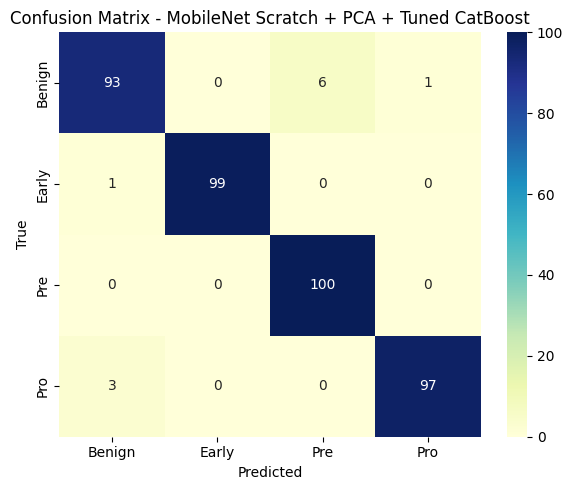

In [17]:
print("🚀 Starting MobileNetV2 Scratch + PCA + Tuned CatBoost pipeline...")

# 1️⃣ Imports
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# 2️⃣ Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# 3️⃣ Define MobileNetV2 Scratch (Minimal)
class MobileNetV2Scratch(nn.Module):
    def __init__(self, num_classes=None):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((7, 7)),
            nn.Conv2d(32, 1280, 1, 1, 0, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.features(x)
        x = nn.AdaptiveAvgPool2d(1)(x)
        x = x.view(x.size(0), -1)
        return x

# 4️⃣ Attach Classifier Head
class MobileNetScratchWithHead(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.base = MobileNetV2Scratch()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(1280, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.base(x)
        return self.classifier(x)

# 5️⃣ Data Preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dir = "/kaggle/input/split-dataset/ALL DATASET/training/d1/Original"
test_dir = "/kaggle/input/split-dataset/ALL DATASET/testing/d1/Original"

train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)
class_names = train_data.classes

# 6️⃣ Train MobileNet Scratch
model = MobileNetScratchWithHead().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("✅ Training MobileNet scratch...")
for epoch in range(10):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    acc = correct / len(train_data)
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f} - Train Acc: {acc*100:.2f}%")

# 7️⃣ Feature Extraction
def extract_features(loader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for images, targets in tqdm(loader, desc="Extracting"):
            images = images.to(device)
            out = model.base(images)
            features.append(out.cpu().numpy())
            labels.extend(targets.numpy())
    return np.vstack(features), np.array(labels)

X_train, y_train = extract_features(train_loader)
X_test, y_test = extract_features(test_loader)

# 8️⃣ PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=200)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 9️⃣ Tuned CatBoost
print("\n🐱 Training Tuned CatBoost...")
cat_model = CatBoostClassifier(
    iterations=700,
    depth=8,
    learning_rate=0.015,
    l2_leaf_reg=2,
    random_seed=42,
    eval_metric='Accuracy',
    verbose=100
)
cat_model.fit(X_train_pca, y_train, eval_set=(X_test_pca, y_test), early_stopping_rounds=25)

# 🔟 Evaluation
y_pred = cat_model.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ CatBoost Accuracy: {acc * 100:.2f}%")
print("✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MobileNet Scratch + PCA + Tuned CatBoost")
plt.tight_layout()
plt.show()


In [39]:
import joblib
import torch
import json
import zipfile

# 1️⃣ Save MobileNetV2 feature extractor
mobilenet_features_only.cpu()  # move to CPU before saving
torch.save(mobilenet_features_only.state_dict(), "mobilenet_scratch_feature_extractor.pth")

# 2️⃣ Save XGBoost model
joblib.dump(xgb_model, "xgb_mobilenet_classifier.pkl")

# 3️⃣ Save class label mapping
class_mapping = {i: name for i, name in enumerate(class_names)}
with open("class_mapping.json", "w") as f:
    json.dump(class_mapping, f)

# 4️⃣ Create ZIP for download
with zipfile.ZipFile("mobilenet_scratch_xgb_package.zip", "w") as zipf:
    zipf.write("mobilenet_scratch_feature_extractor.pth")
    zipf.write("xgb_mobilenet_classifier.pkl")
    zipf.write("class_mapping.json")

print("✅ All components saved and zipped: mobilenet_scratch_xgb_package.zip")


✅ All components saved and zipped: mobilenet_scratch_xgb_package.zip


VGG+PCA+SVM

VGG16+SVM

In [ ]:
import torch.nn as nn
class VGG16Scratch(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            # Conv Layer Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
    def forward(self, x):
        return self.features(x)


In [7]:
class VGG16ScratchWithHead(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.features = VGG16Scratch().features  # Same feature extractor
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x).view(x.size(0), -1)
        return self.classifier(x)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# ✅ Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# ✅ Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ✅ Load train/test data
train_dir = "/kaggle/input/split-dataset/ALL DATASET/training/d1/Original"
test_dir = "/kaggle/input/split-dataset/ALL DATASET/testing/d1/Original"

train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

# ✅ Train/Test loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# ✅ Initialize model
model = VGG16ScratchWithHead(num_classes=4).to(device)

# ✅ Hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10

# ✅ Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss, correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = correct / len(train_data)

    # 🔥 Evaluate on Test Set
    model.eval()
    correct_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct_test += (outputs.argmax(1) == labels).sum().item()
    test_acc = correct_test / len(test_data)

    # 🖨️ Print Train and Test Accuracy
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f} - Train Acc: {train_acc*100:.2f}% - Test Acc: {test_acc*100:.2f}%")


Epoch 1/10 - Loss: 69.3483 - Train Acc: 24.81% - Test Acc: 25.00%
Epoch 2/10 - Loss: 69.3303 - Train Acc: 26.88% - Test Acc: 25.00%
Epoch 3/10 - Loss: 69.2103 - Train Acc: 26.62% - Test Acc: 50.00%
Epoch 4/10 - Loss: 38.4215 - Train Acc: 65.38% - Test Acc: 78.25%
Epoch 5/10 - Loss: 26.3715 - Train Acc: 75.69% - Test Acc: 76.25%
Epoch 6/10 - Loss: 21.3744 - Train Acc: 80.62% - Test Acc: 86.00%
Epoch 7/10 - Loss: 18.8985 - Train Acc: 81.88% - Test Acc: 81.25%
Epoch 8/10 - Loss: 17.9513 - Train Acc: 83.81% - Test Acc: 87.25%
Epoch 9/10 - Loss: 16.8229 - Train Acc: 85.31% - Test Acc: 83.75%
Epoch 10/10 - Loss: 16.3298 - Train Acc: 86.06% - Test Acc: 87.00%


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm


In [32]:
# ✅ Extract just the feature extractor part
feature_model = nn.Sequential(model.features, model.pool).to(device)
feature_model.eval()

def extract_vgg_features(dataloader):
    features, labels = [], []
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Extracting Features"):
            images = images.to(device)
            out = feature_model(images)
            out = out.view(out.size(0), -1).cpu().numpy()
            features.append(out)
            labels.extend(targets.numpy())
    return np.vstack(features), np.array(labels)

# 🔁 Re-extract features
print("⏳ Re-extracting train features...")
X_train, y_train = extract_vgg_features(train_loader)

print("⏳ Re-extracting test features...")
X_test, y_test = extract_vgg_features(test_loader)


⏳ Re-extracting train features...


Extracting Features: 100%|██████████| 50/50 [00:11<00:00,  4.53it/s]


⏳ Re-extracting test features...


Extracting Features: 100%|██████████| 13/13 [00:03<00:00,  4.04it/s]


⏳ Training SVM on PCA features...

✅ PCA + SVM Accuracy: 93.75%

✅ Classification Report:
               precision    recall  f1-score   support

      Benign       0.88      0.87      0.87       100
       Early       0.88      0.90      0.89       100
         Pre       0.99      1.00      1.00       100
         Pro       1.00      0.98      0.99       100

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



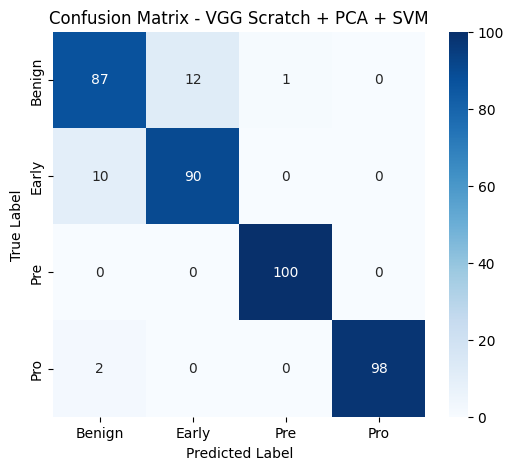

In [33]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ PCA (keep 200 components or adjust as needed)
pca = PCA(n_components=200)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# ✅ Train SVM on PCA-transformed features
svm_model = SVC(kernel='rbf', C=10, gamma='scale')
print("⏳ Training SVM on PCA features...")
svm_model.fit(X_train_pca, y_train)

# ✅ Predictions & evaluation
y_pred = svm_model.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)

print(f"\n✅ PCA + SVM Accuracy: {acc * 100:.2f}%")
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - VGG Scratch + PCA + SVM")
plt.show()


In [34]:
import joblib
import torch
import json

# 1️⃣ Save the VGG feature extractor
vgg_feature_extractor = nn.Sequential(model.features, model.pool)
torch.save(vgg_feature_extractor.state_dict(), "vgg16_scratch_feature_extractor.pth")

# 2️⃣ Save the trained SVM classifier
joblib.dump(svm_model, "svm_classifier.pkl")

# 3️⃣ Save the PCA transformer
joblib.dump(pca, "pca_transform.pkl")

# 4️⃣ Save class names (index-to-label mapping)
class_mapping = {i: name for i, name in enumerate(class_names)}
with open("class_mapping.json", "w") as f:
    json.dump(class_mapping, f)

# ✅ Zip everything for download or deployment
import zipfile

with zipfile.ZipFile("vgg_scratch_svm_package.zip", "w") as zipf:
    zipf.write("vgg16_scratch_feature_extractor.pth")
    zipf.write("svm_classifier.pkl")
    zipf.write("pca_transform.pkl")
    zipf.write("class_mapping.json")

print("✅ All models & components saved and zipped.")


✅ All models & components saved and zipped.


ShuffleNet +PCA+RandomForest 

shufflenet+Randomforest 

In [ ]:
import torch
import torch.nn as nn

# ShuffleNet helper blocks
class ChannelShuffle(nn.Module):
    def __init__(self, groups):
        super().__init__()
        self.groups = groups

    def forward(self, x):
        batch_size, num_channels, height, width = x.size()
        channels_per_group = num_channels // self.groups
        x = x.view(batch_size, self.groups, channels_per_group, height, width)
        x = x.transpose(1, 2).contiguous()
        return x.view(batch_size, -1, height, width)

class ShuffleUnit(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        mid_channels = out_channels // 2
        self.stride = stride

        if stride > 1:
            self.branch1 = nn.Sequential(
                nn.Conv2d(in_channels, in_channels, 3, stride, 1, groups=in_channels, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.Conv2d(in_channels, mid_channels, 1, 1, 0, bias=False),
                nn.BatchNorm2d(mid_channels),
                nn.ReLU(inplace=True)
            )
        else:
            self.branch1 = nn.Identity()
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels if stride > 1 else mid_channels, mid_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, mid_channels, 3, stride, 1, groups=mid_channels, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.Conv2d(mid_channels, mid_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
        )
        self.shuffle = ChannelShuffle(groups=2)

    def forward(self, x):
        if self.stride == 1:
            x1, x2 = x.chunk(2, dim=1)
            out = torch.cat((x1, self.branch2(x2)), dim=1)
        else:
            out = torch.cat((self.branch1(x), self.branch2(x)), dim=1)
        return self.shuffle(out)

class ShuffleNetV2Scratch(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 24, 3, 2, 1, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True)
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.stage2 = self._make_stage(24, 116, 4)
        self.stage3 = self._make_stage(116, 232, 8)
        self.stage4 = self._make_stage(232, 464, 4)

        self.conv5 = nn.Sequential(
            nn.Conv2d(464, 1024, 1, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.AdaptiveAvgPool2d(1)

        # FC classifier head (temporary)
        self.classifier = nn.Sequential(
            
            nn.Dropout(0.5),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
)

    def _make_stage(self, in_channels, out_channels, num_blocks):
        layers = [ShuffleUnit(in_channels, out_channels, stride=2)]
        for _ in range(num_blocks - 1):
            layers.append(ShuffleUnit(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.conv5(x)
        x = self.pool(x).view(x.size(0), -1)
        return self.classifier(x)


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ✅ Define your transforms (same as before)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

# ✅ Define train & test directories
train_dir = "/kaggle/input/split-dataset/ALL DATASET/training/d1/Original"
test_dir = "/kaggle/input/split-dataset/ALL DATASET/testing/d1/Original"

# ✅ Load data
train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# ✅ Class names
class_names = train_data.classes


In [4]:
# ✅ Add this first
device = "cuda" if torch.cuda.is_available() else "cpu"

# ✅ Then define your model and training components
model = ShuffleNetV2Scratch().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10

# ✅ Now start training
for epoch in range(num_epochs):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    
    train_acc = correct / len(train_data)

    # 🔥 Evaluate on Test Set
    model.eval()
    correct_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            correct_test += (outputs.argmax(1) == labels).sum().item()
    test_acc = correct_test / len(test_data)

    # 🖨️ Print Train and Test Accuracy
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss:.4f} - Train Acc: {train_acc*100:.2f}% - Test Acc: {test_acc*100:.2f}%")


Epoch 1/10 - Loss: 65.4177 - Train Acc: 37.50% - Test Acc: 25.00%
Epoch 2/10 - Loss: 48.7253 - Train Acc: 56.75% - Test Acc: 66.25%
Epoch 3/10 - Loss: 39.5691 - Train Acc: 64.44% - Test Acc: 71.00%
Epoch 4/10 - Loss: 34.7922 - Train Acc: 70.56% - Test Acc: 79.50%
Epoch 5/10 - Loss: 29.7610 - Train Acc: 74.44% - Test Acc: 76.75%
Epoch 6/10 - Loss: 29.3677 - Train Acc: 75.62% - Test Acc: 77.50%
Epoch 7/10 - Loss: 26.5914 - Train Acc: 78.19% - Test Acc: 81.25%
Epoch 8/10 - Loss: 25.2310 - Train Acc: 80.75% - Test Acc: 86.25%
Epoch 9/10 - Loss: 23.7401 - Train Acc: 80.94% - Test Acc: 85.50%
Epoch 10/10 - Loss: 18.8252 - Train Acc: 85.44% - Test Acc: 87.75%


In [30]:
!pip install torchsummary


In [ ]:
class ShuffleNetV2FeatureExtractor(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            base_model.conv1,
            base_model.maxpool,
            base_model.stage2,
            base_model.stage3,
            base_model.stage4,
            base_model.conv5,
            base_model.pool  # Output: [B, 1024, 1, 1]
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        return x.view(x.size(0), -1)  # Flatten to [B, 1024]


In [36]:
shufflenet_features_only = ShuffleNetV2FeatureExtractor(model).to(device)


In [37]:
X_train, y_train = extract_features(shufflenet_features_only, train_loader, device)
X_test, y_test = extract_features(shufflenet_features_only, test_loader, device)

print("✅ Feature extraction done.")


Extracting Features: 100%|██████████| 13/13 [00:01<00:00, 10.61it/s]

✅ Feature extraction done.


In [41]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize before PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


Training Random Forest...

✅ Random Forest Accuracy: 94.50%

✅ Classification Report:

              precision    recall  f1-score   support

      Benign       0.94      0.83      0.88       100
       Early       0.93      0.97      0.95       100
         Pre       0.99      0.99      0.99       100
         Pro       0.92      0.99      0.95       100

    accuracy                           0.94       400
   macro avg       0.95      0.95      0.94       400
weighted avg       0.95      0.94      0.94       400



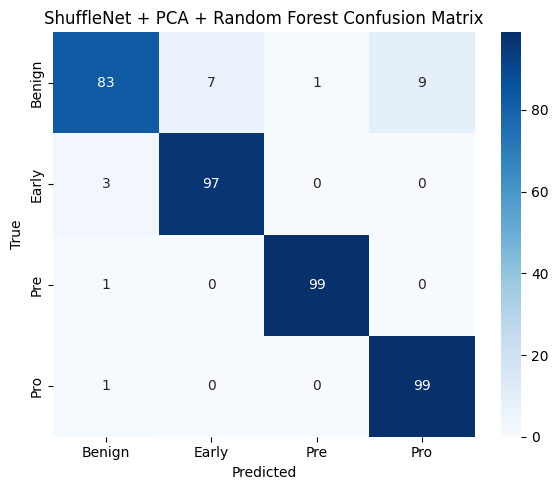

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
# 🎯 Train Random Forest
print("Training Random Forest...")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_pca, y_train)

# ✅ Predict
y_pred_rf = rf_clf.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred_rf)
print(f"\n✅ Random Forest Accuracy: {acc*100:.2f}%\n")

# 📊 Classification Report
print("✅ Classification Report:\n")
print(classification_report(y_test, y_pred_rf, target_names=class_names))

# 📉 Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ShuffleNet + PCA + Random Forest Confusion Matrix")
plt.tight_layout()
plt.show()



conv+ViT

In [11]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from transformers import ViTModel

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data transformation
IMG_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Dataset paths
train_dir = "/kaggle/input/split-dataset/ALL DATASET/training/d1/Original"
test_dir = "/kaggle/input/split-dataset/ALL DATASET/testing/d1/Original"

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Define Hybrid Conv-ViT Model
class HybridConvViT(nn.Module):
    def __init__(self, num_classes=4):
        super(HybridConvViT, self).__init__()
        
        # Convolutional Feature Extractor
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: (64, 112, 112)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # Output: (128, 56, 56)
        )

        # Load Pretrained ViT
        self.vit = ViTModel.from_pretrained("/kaggle/input/vit-base-patch16-224-in21k-folder")

        # Freeze ViT layers initially
        for param in self.vit.parameters():
            param.requires_grad = False

        # Linear projection to match ViT input channels
        self.projection = nn.Conv2d(128, 3, kernel_size=1)  # Convert CNN output to 3-channel image

        # Custom Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(self.vit.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)  # CNN Feature Extraction
        x = self.projection(x)   # Convert to 3-channel image
        x = nn.functional.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)  # Resize to ViT input size
        x = self.vit(pixel_values=x).last_hidden_state[:, 0, :]  # ViT Encoder
        x = self.classifier(x)  # Classification Head
        return x

# Initialize Model
model = HybridConvViT(num_classes=4).to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Training Loop
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(dataloader), correct / len(dataloader.dataset)

# Evaluation Loop
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(dataloader), correct / len(dataloader.dataset)

# Train the Model
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}%")
    print(f"Test  Loss: {test_loss:.4f}, Accuracy: {test_acc*100:.2f}%\n")

# Save Model
torch.save(model.state_dict(), "hybrid_conv_vit.pth")
print("Model training complete and saved.")


Epoch 1/10
Train Loss: 0.7453, Accuracy: 78.06%
Test  Loss: 0.3175, Accuracy: 90.25%

Epoch 2/10
Train Loss: 0.1227, Accuracy: 97.56%
Test  Loss: 0.0695, Accuracy: 98.75%

Epoch 3/10
Train Loss: 0.0548, Accuracy: 98.56%
Test  Loss: 0.0628, Accuracy: 98.00%

Epoch 4/10
Train Loss: 0.0365, Accuracy: 99.00%
Test  Loss: 0.0297, Accuracy: 99.50%

Epoch 5/10
Train Loss: 0.0250, Accuracy: 99.38%
Test  Loss: 0.0313, Accuracy: 98.75%

Epoch 6/10
Train Loss: 0.0174, Accuracy: 99.56%
Test  Loss: 0.0218, Accuracy: 99.50%

Epoch 7/10
Train Loss: 0.0093, Accuracy: 99.81%
Test  Loss: 0.0278, Accuracy: 99.50%

Epoch 8/10
Train Loss: 0.0064, Accuracy: 99.94%
Test  Loss: 0.0200, Accuracy: 99.50%

Epoch 9/10
Train Loss: 0.0054, Accuracy: 99.94%
Test  Loss: 0.0183, Accuracy: 99.50%

Epoch 10/10
Train Loss: 0.0045, Accuracy: 99.94%
Test  Loss: 0.0199, Accuracy: 99.50%

Model training complete and saved.


LeukVision 

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image
import numpy as np
import pywt


In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None, wavelet_dim=4096):
        self.dataset = datasets.ImageFolder(root=root_dir)
        self.transform = transform
        self.wavelet_dim = wavelet_dim

    def __len__(self):
        return len(self.dataset)

    def extract_wavelet_features(self, image):
        image = np.array(image.convert("L"), dtype=np.float32)
        coeffs = pywt.dwt2(image, 'haar')
        LL, (LH, HL, HH) = coeffs
        features = np.concatenate([LL.flatten(), LH.flatten(), HL.flatten(), HH.flatten()])
        if features.size >= self.wavelet_dim:
            features = features[:self.wavelet_dim]
        else:
            features = np.pad(features, (0, self.wavelet_dim - features.size))
        return torch.tensor(features, dtype=torch.float32)

    def __getitem__(self, idx):
        path, label = self.dataset.samples[idx]
        image = Image.open(path).convert("RGB")
        wavelet_feat = self.extract_wavelet_features(image)
        if self.transform:
            image = self.transform(image=np.array(image))['image']
        return image, wavelet_feat, label


In [8]:
# Define your dataset paths
train_dir = "/kaggle/input/split-dataset/ALL DATASET/training/d1/Original"
test_dir = "/kaggle/input/split-dataset/ALL DATASET/testing/d1/Original"

In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_SIZE = 224

albumentations_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.2),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])


In [11]:

train_dataset = CustomDataset(train_dir, transform=albumentations_transform)
test_dataset = CustomDataset(test_dir, transform=albumentations_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [12]:
import torch.optim as optim


In [1]:
import torch
import torch.nn as nn

# Bottleneck block for ResNet50
class Bottleneck(nn.Module):
    expansion = 4  # output channels = 4x input channels

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# ResNet50 model
class ResNet50(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet50, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(Bottleneck, 64, 3)
        self.layer2 = self._make_layer(Bottleneck, 128, 4, stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, 6, stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import ViTModel

class FusionModel(nn.Module):
    def __init__(self, num_classes=4, prompt_dim=128, wavelet_dim=4096):
        super(FusionModel, self).__init__()

        resnet = ResNet50(num_classes=1000)
        resnet.fc = nn.Identity()
        self.cnn = resnet
        self.cnn_out = 2048

        # ✅ ViT (frozen)
        self.vit = ViTModel.from_pretrained("/kaggle/input/vit-base-patch16-224-in21k-folder")
        for param in self.vit.parameters():
            param.requires_grad = False
        self.vit_out = self.vit.config.hidden_size  # 768

        # ✅ Prompt Embedding
        self.prompt_embed = nn.Embedding(num_classes, prompt_dim)

        # ✅ Final classifier
        total_features = self.cnn_out + self.vit_out + prompt_dim + wavelet_dim
        self.classifier = nn.Sequential(
            nn.LayerNorm(total_features),
            nn.Linear(total_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, images, wavelet_feats, labels):
        # CNN features
        cnn_feats = self.cnn(images)  # [B, 2048]

        # ViT expects pixel_values in [0, 1] → convert from [-1, 1]
        vit_input = (images * 0.5) + 0.5
        vit_out = self.vit(pixel_values=vit_input).last_hidden_state[:, 0, :]  # [B, 768]

        # Prompt embeddings
        prompt = self.prompt_embed(labels)  # [B, 128]

        # Normalize wavelet features per sample
        wavelet_feats = (wavelet_feats - wavelet_feats.mean(dim=1, keepdim=True)) / (wavelet_feats.std(dim=1, keepdim=True) + 1e-5)

        # Final fusion
        fused = torch.cat([cnn_feats, vit_out, prompt, wavelet_feats], dim=1)
        return self.classifier(fused)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FusionModel(num_classes=4, prompt_dim=128, wavelet_dim=4096).to(device)


<ipython-input-13-363a14d30e46>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/kaggle/input/resnet/resnet50-0676ba61.pth")


In [15]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)


In [16]:
from sklearn.metrics import accuracy_score

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, all_preds, all_labels = 0, [], []

    for images, wavelet_feats, labels in loader:
        images, wavelet_feats, labels = images.to(device), wavelet_feats.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images, wavelet_feats, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return total_loss / len(loader), acc

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, all_preds, all_labels = 0, [], []

    with torch.no_grad():
        for images, wavelet_feats, labels in loader:
            images, wavelet_feats, labels = images.to(device), wavelet_feats.to(device), labels.to(device)
            outputs = model(images, wavelet_feats, labels)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return total_loss / len(loader), acc


In [17]:
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc*100:.2f}%")
    print("-" * 60)


Epoch 1/10
Train Loss: 0.2123 | Train Acc: 92.38%
Test  Loss: 0.0707 | Test  Acc: 98.50%
------------------------------------------------------------
Epoch 2/10
Train Loss: 0.0285 | Train Acc: 99.12%
Test  Loss: 0.0017 | Test  Acc: 100.00%
------------------------------------------------------------
Epoch 3/10
Train Loss: 0.0027 | Train Acc: 100.00%
Test  Loss: 0.0011 | Test  Acc: 100.00%
------------------------------------------------------------
Epoch 4/10
Train Loss: 0.0024 | Train Acc: 99.94%
Test  Loss: 0.0013 | Test  Acc: 100.00%
------------------------------------------------------------
Epoch 5/10
Train Loss: 0.0007 | Train Acc: 100.00%
Test  Loss: 0.0002 | Test  Acc: 100.00%
------------------------------------------------------------
Epoch 6/10
Train Loss: 0.0004 | Train Acc: 100.00%
Test  Loss: 0.0002 | Test  Acc: 100.00%
------------------------------------------------------------
Epoch 7/10
Train Loss: 0.0006 | Train Acc: 100.00%
Test  Loss: 0.0002 | Test  Acc: 100.00%
-

In [18]:
torch.save(model.state_dict(), "vit_resnet_fusion_model.pth")
print("✅ Fusion model saved as 'vit_resnet_fusion_model.pth'")


✅ Fusion model saved as 'vit_resnet_fusion_model.pth'


In [ ]:
import matplotlib.pyplot as plt
def show_predictions_one_per_class(model, dataset, device):
    model.eval()
    found = [False] * 4
    class_names = dataset.dataset.classes
    print("🔍 Showing one sample from each class with prediction:\n")
    plt.figure(figsize=(12, 8))
    shown = 0
    with torch.no_grad():
        for i in range(len(dataset)):
            image, wavelet_feat, label = dataset[i]
            if found[label]:
                continue
            # Prepare input
            image_tensor = image.unsqueeze(0).to(device)
            wavelet_feat_tensor = wavelet_feat.unsqueeze(0).to(device)
            label_tensor = torch.tensor([label]).to(device)
            # Predict
            output = model(image_tensor, wavelet_feat_tensor, label_tensor)
            pred = torch.argmax(output, dim=1).item()
            # Reverse normalize image to [0,1] for display
            img_disp = image.permute(1, 2, 0).cpu().numpy()
            img_disp = ((img_disp * 0.5) + 0.5).clip(0, 1)
            # Plot image
            plt.subplot(2, 2, shown + 1)
            plt.imshow(img_disp)
            plt.title(f"Actual: {class_names[label]}\nPredicted: {class_names[pred]}")
            plt.axis("off")
            found[label] = True
            shown += 1
            if all(found):
                break
    plt.tight_layout()
    plt.show()


🔍 Showing one sample from each class with prediction:



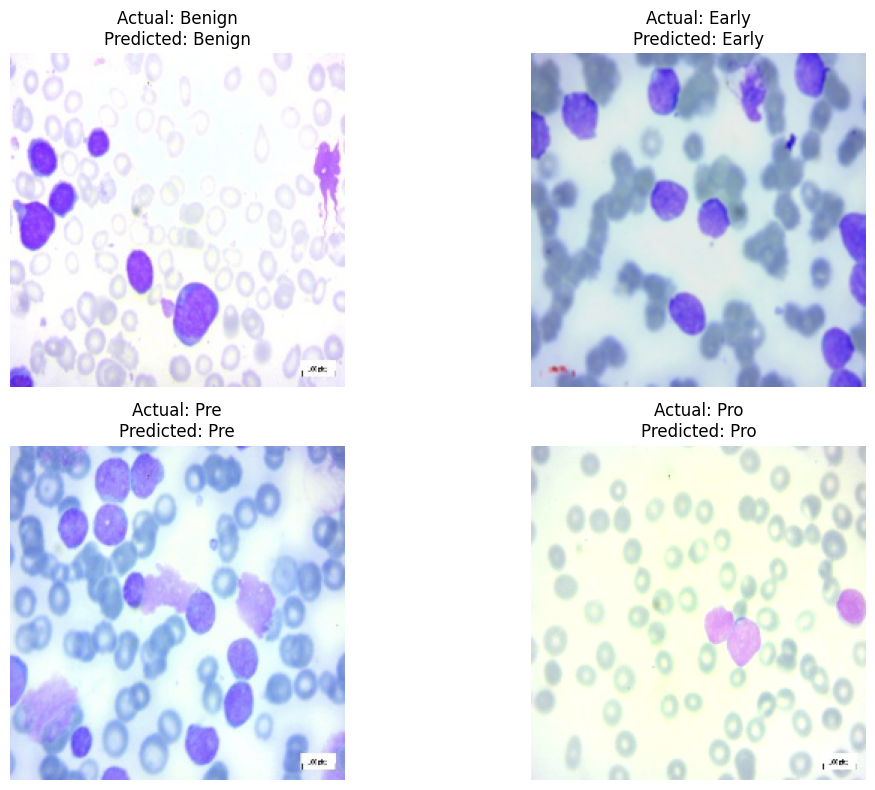

In [48]:
show_predictions_one_per_class(model, test_dataset, device)


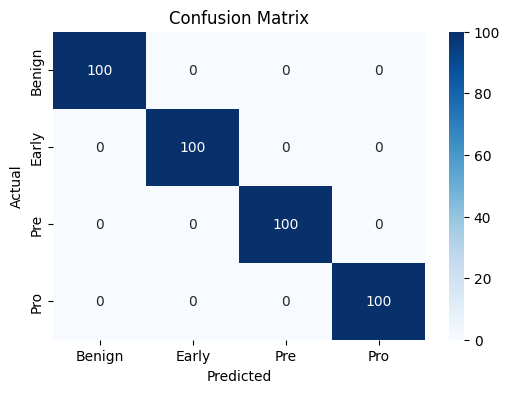


Classification Report:

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       100
       Early       1.00      1.00      1.00       100
         Pre       1.00      1.00      1.00       100
         Pro       1.00      1.00      1.00       100

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.dataset.classes, yticklabels=train_dataset.dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(labels, preds, target_names=train_dataset.dataset.classes))


Attention Rollout 

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2

def vit_attention_rollout(model, image_tensor, device):
    model.eval()

    # Get all attention weights from ViT
    with torch.no_grad():
        vit_outputs = model.vit(pixel_values=image_tensor.to(device), output_attentions=True)
        attentions = vit_outputs.attentions  # list of [B, heads, tokens, tokens]

    # Stack and average over heads
    att_mat = torch.stack(attentions)  # [layers, B, heads, N, N]
    att_mat = att_mat[:, 0]  # Use batch index 0 → shape [layers, heads, N, N]
    att_mat = att_mat.mean(dim=1)  # Average over heads → shape [layers, N, N]

    # Add identity matrix and normalize rows
    residual_att = torch.eye(att_mat.size(-1)).to(device)
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1, keepdim=True)

    # Multiply attention matrices through layers
    joint_attentions = aug_att_mat[0]
    for i in range(1, aug_att_mat.size(0)):
        joint_attentions = aug_att_mat[i] @ joint_attentions

    # Attention from CLS token to others
    mask = joint_attentions[0, 1:]  # exclude CLS token
    num_patches = mask.size(0)
    side = int(num_patches ** 0.5)
    mask = mask.reshape(side, side).cpu().numpy()
    mask = cv2.resize(mask, (224, 224))

    return mask


In [52]:
def show_vit_attention(model, dataset, device, class_idx=0):
    # Get one sample from given class
    for i in range(len(dataset)):
        image, _, label = dataset[i]
        if label == class_idx:
            break

    image_input = image.unsqueeze(0).to(device)

    # Run attention rollout
    attention_map = vit_attention_rollout(model, image_input, device)

    # Prepare image for overlay
    img_disp = image.permute(1, 2, 0).cpu().numpy()
    img_disp = ((img_disp * 0.5) + 0.5).clip(0, 1)

    # Overlay attention
    attention_overlay = cv2.applyColorMap(np.uint8(255 * attention_map), cv2.COLORMAP_JET)
    attention_overlay = np.float32(attention_overlay) / 255
    overlayed_img = 0.6 * attention_overlay + 0.4 * img_disp

    # Plot
    plt.figure(figsize=(6, 4))
    class_names = dataset.dataset.classes
    plt.imshow(overlayed_img)
    plt.title(f"ViT Attention Rollout\nClass: {class_names[label]}")
    plt.axis("off")
    plt.show()


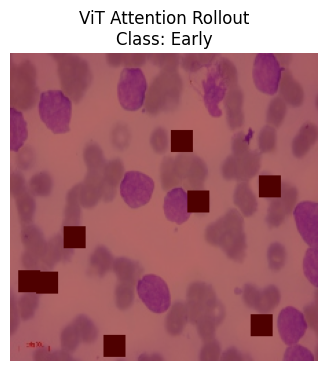

In [54]:
show_vit_attention(model, test_dataset, device, class_idx=1)  # Try 0–3


Noise added 

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_SIZE = 224

strong_noisy_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.7),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),  # fixed range ✅
    A.GaussNoise(var_limit=(50.0, 100.0), p=0.7),
    A.ISONoise(p=0.4),
    A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
    A.RandomShadow(p=0.4),
    A.CoarseDropout(max_holes=16, max_height=32, max_width=32, p=0.7),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])


In [7]:
from PIL import Image
import torch
import numpy as np
import pywt
from torchvision import datasets

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None, wavelet_dim=4096):
        self.dataset = datasets.ImageFolder(root=root_dir)
        self.transform = transform
        self.wavelet_dim = wavelet_dim

    def __len__(self):
        return len(self.dataset)

    def extract_wavelet_features(self, image):
        image = np.array(image.convert("L"), dtype=np.float32)
        coeffs = pywt.dwt2(image, 'haar')
        LL, (LH, HL, HH) = coeffs
        features = np.concatenate([LL.flatten(), LH.flatten(), HL.flatten(), HH.flatten()])
        if features.size >= self.wavelet_dim:
            features = features[:self.wavelet_dim]
        else:
            features = np.pad(features, (0, self.wavelet_dim - features.size))
        return torch.tensor(features, dtype=torch.float32)

    def __getitem__(self, idx):
        path, label = self.dataset.samples[idx]
        image = Image.open(path).convert("RGB")
        wavelet_feat = self.extract_wavelet_features(image)

        if self.transform:
            # Albumentations expects np.array input
            image = self.transform(image=np.array(image))['image']  # returns tensor

        return image, wavelet_feat, label


In [ ]:
import torch
import torch.nn as nn

# Bottleneck block for ResNet50
class Bottleneck(nn.Module):
    expansion = 4  # output channels = 4x input channels

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# ResNet50 model
class ResNet50(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet50, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(Bottleneck, 64, 3)
        self.layer2 = self._make_layer(Bottleneck, 128, 4, stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, 6, stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [ ]:
import torch.nn as nn
import torchvision.models as models
from transformers import ViTModel

class FusionModel(nn.Module):
    def __init__(self, num_classes=4, prompt_dim=128, wavelet_dim=4096):
        super(FusionModel, self).__init__()

    
        resnet = ResNet50(num_classes=1000)
        resnet.fc = nn.Identity()
        self.cnn = resnet
        self.cnn_out = 2048


        # ✅ Frozen ViT
        self.vit = ViTModel.from_pretrained("/kaggle/input/vit-base-patch16-224-in21k-folder")
        for param in self.vit.parameters():
            param.requires_grad = False
        self.vit_out = self.vit.config.hidden_size  # 768

        # ✅ Learnable Prompt Embeddings
        self.prompt_embed = nn.Embedding(num_classes, prompt_dim)

        # ✅ Final Classifier
        total_features = self.cnn_out + self.vit_out + prompt_dim + wavelet_dim
        self.classifier = nn.Sequential(
            nn.LayerNorm(total_features),
            nn.Linear(total_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, images, wavelet_feats, labels):
        # CNN Features
        cnn_feats = self.cnn(images)  # [B, 2048]

        # ViT Input: Convert from [-1,1] to [0,1]
        vit_input = (images * 0.5) + 0.5
        vit_out = self.vit(pixel_values=vit_input).last_hidden_state[:, 0, :]  # CLS token [B, 768]

        # Prompt embeddings based on class label
        prompt = self.prompt_embed(labels)  # [B, 128]

        # Normalize wavelet features
        wavelet_feats = (wavelet_feats - wavelet_feats.mean(dim=1, keepdim=True)) / \
                        (wavelet_feats.std(dim=1, keepdim=True) + 1e-5)

        # Concatenate and classify
        fused = torch.cat([cnn_feats, vit_out, prompt, wavelet_feats], dim=1)
        return self.classifier(fused)


In [ ]:
from torch.utils.data import DataLoader

train_dataset = CustomDataset(
    root_dir="/kaggle/input/split-dataset/ALL DATASET/training/d1/Original",
    transform=strong_noisy_transform
)


test_dataset = CustomDataset(
    root_dir="/kaggle/input/split-dataset/ALL DATASET/testing/d1/Original",
    transform=strong_noisy_transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FusionModel(num_classes=4, prompt_dim=128, wavelet_dim=4096).to(device)

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)


<ipython-input-8-6c88e0629b48>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/kaggle/input/resnet/resnet50-0676ba61.pth")


In [20]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, all_preds, all_labels = 0, [], []

    for images, wavelet_feats, labels in loader:
        images, wavelet_feats, labels = images.to(device), wavelet_feats.to(device), labels.to(device)

        # 🔁 Randomly flip some labels (10%) to test robustness
        if torch.rand(1).item() < 0.1:
            labels = torch.randint(0, 4, labels.shape, dtype=torch.long).to(device)

        optimizer.zero_grad()

        # ✅ Use random dummy labels instead of true labels
        dummy_labels = torch.randint(0, 4, labels.shape, dtype=torch.long).to(device)

        outputs = model(images, wavelet_feats, dummy_labels)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return total_loss / len(loader), acc


In [21]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, all_preds, all_labels = 0, [], []

    with torch.no_grad():
        for images, wavelet_feats, labels in loader:
            images, wavelet_feats, labels = images.to(device), wavelet_feats.to(device), labels.to(device)

            # ✅ Use random dummy labels during evaluation too
            dummy_labels = torch.randint(0, 4, labels.shape, dtype=torch.long).to(device)
            outputs = model(images, wavelet_feats, dummy_labels)

            loss = criterion(outputs, labels)
            total_loss += loss.item()
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    return total_loss / len(loader), acc


In [13]:
import torch.optim as optim


In [22]:
optimizer = optim.Adam(model.parameters(), lr=2e-4)


In [16]:
from sklearn.metrics import accuracy_score


In [23]:
EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Test  Loss: {test_loss:.4f} | Test  Acc: {test_acc*100:.2f}%")
    print("-" * 60)


Epoch 1/10
Train Loss: 0.9798 | Train Acc: 63.06%
Test  Loss: 0.5959 | Test  Acc: 76.75%
------------------------------------------------------------
Epoch 2/10
Train Loss: 0.6673 | Train Acc: 80.25%
Test  Loss: 0.4467 | Test  Acc: 83.00%
------------------------------------------------------------
Epoch 3/10
Train Loss: 0.6885 | Train Acc: 83.44%
Test  Loss: 0.4002 | Test  Acc: 90.25%
------------------------------------------------------------
Epoch 4/10
Train Loss: 0.4238 | Train Acc: 90.88%
Test  Loss: 0.2388 | Test  Acc: 93.25%
------------------------------------------------------------
Epoch 5/10
Train Loss: 0.5498 | Train Acc: 88.31%
Test  Loss: 0.3530 | Test  Acc: 92.75%
------------------------------------------------------------
Epoch 6/10
Train Loss: 0.5616 | Train Acc: 87.94%
Test  Loss: 0.3263 | Test  Acc: 91.00%
------------------------------------------------------------
Epoch 7/10
Train Loss: 0.5953 | Train Acc: 86.25%
Test  Loss: 0.2322 | Test  Acc: 93.50%
-----------